In [9]:
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype import Workflow, Node

In [10]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [11]:
experiment_dir = '/home/soyeon/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers (remember we use only right handed subjects)
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', 
               '16', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28']

# task name
task_name = "socialcomparison"

# Smoothing widths used during preprocessing
fwhm = [6]

# Template to normalize to
template = '/opt/spm12/tpm/TPM.nii'

In [12]:
# Gunzip - unzip the anatomical image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

In [13]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        'sub-{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'anat': opj(output_dir, 'social/fmriprep','sub-{subject_id}', 
                         'anat', 'sub-{subject_id}_t1w_preproc.nii.gz')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions


In [7]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('fwhm_id', 'fwhm_id')]),
                 (selectfiles, normalize, [('con', 'apply_to_files')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, normalize, [('out_file', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 ])

181030-17:50:26,656 nipype.workflow INFO:
	 Generated workflow graph: /home/soyeon/output/workingdir/spmflow/graph.png (graph2use=colored, simple_form=True).


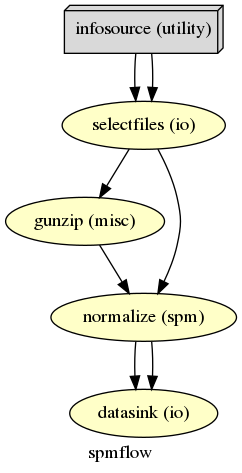

In [8]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph.png'))

In [12]:
spmflow.run('MultiProc', plugin_args={'n_procs': 2})

181023-17:02:37,524 nipype.workflow INFO:
	 Workflow spmflow settings: ['check', 'execution', 'logging', 'monitoring']
181023-17:02:37,568 nipype.workflow INFO:
	 Running in parallel.
181023-17:02:37,573 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 2/2.
181023-17:02:37,624 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/soyeon/output/workingdir/spmflow/_fwhm_id_6_subject_id_05/selectfiles".181023-17:02:37,625 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/soyeon/output/workingdir/spmflow/_fwhm_id_6_subject_id_04/selectfiles".

181023-17:02:37,633 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181023-17:02:37,635 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181023-17:02:37,643 nipype.workflow INFO:
	 [Node] Finished "spmflow.selectfiles".
181023-17:02:37,648 nipype.workflow

In [1]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
# anatimg = '/opt/spm12/canonical/avg152T1.nii'
anatimg = '/home/soyeon/data/fmri_study/pad/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'
#anatimg = '/home/soyeon/output/datasink/norm_spm/sub-04_fwhm6/wsub-04_T1w_brain.nii'

/home/soyeon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


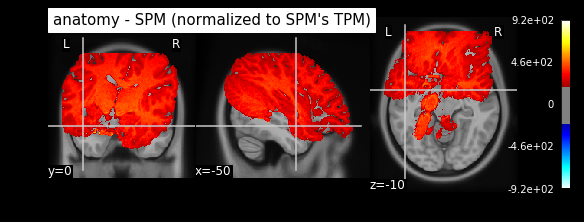

In [2]:
plot_stat_map(
    '/home/soyeon/output/datasink/norm_spm/sub-01_fwhm6/wsub-01_T1w_brain.nii',
    title='anatomy - SPM (normalized to SPM\'s TPM)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10));

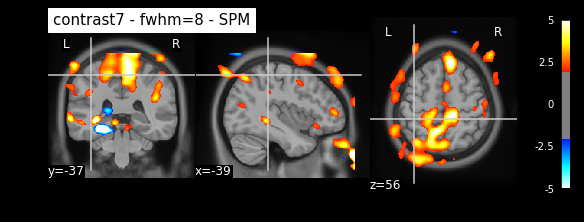

In [4]:
plot_stat_map(
    '/home/soyeon/output/datasink/norm_spm/sub-04_fwhm6/wcon_0007.nii', title='contrast7 - fwhm=8 - SPM',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56));

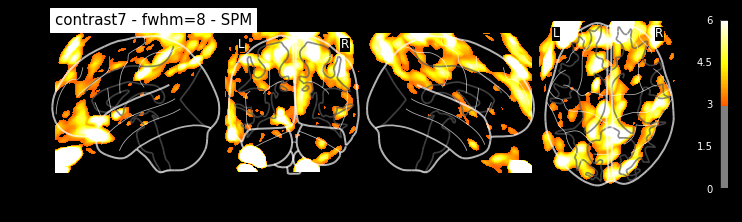

In [9]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/home/soyeon/output/datasink/norm_spm/sub-01_fwhm6/wcon_0007.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast7 - fwhm=8 - SPM');